In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, log_loss


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('/kaggle/input/ad-clicks/data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


## Анализ
Хочу посмотреть в какие дни сделано больше всего кликов, также интересно в целом в какое время суток больше кликов. Мое предположение, что есть некоторая связь между днем недели, времени суток и сделанным кликом. В дополнении хочу в целом посмотреть на датасет и посмотреть на уникальные значения фичей.

In [3]:
def plotting(x, y, lx, ly, title):
    fig, ax = plt.subplots()

    ax.bar(x, y, width=0.5, edgecolor="blue", linewidth=0.7)

    ax.set(xlabel=lx, ylabel=ly, title=title)

    plt.xticks(rotation=45)
    plt.ticklabel_format(axis='y', style='plain')

    plt.tight_layout()
    plt.show()


Пустые значения в данных: 59439
Уникальные значения:
 zone_id - 3444
 banner_id - 1633
 country id - 17
АНАЛИЗ ДАТАСЕТА
Top 3 значения для zone_id с наибольшим кол-во кликов:
zone_id
14    93795
17    63758
27    29002
Name: clicks, dtype: int64
Top 3 значения для banner_id с наибольшим кол-во кликов:
banner_id
46    24751
22    18124
2     10377
Name: clicks, dtype: int64
Top 3 значения для country_id с наибольшим кол-во кликов:
country_id
0    135643
1     47492
5     43165
Name: clicks, dtype: int64
Количество кликов:
 0: 15399223 1: 422249
Клики в разные периоды времени:
Early Morning: 52183
Morning: 46214
Noon: 51981
Evening: 76619
Night: 108588
Late Night: 86664


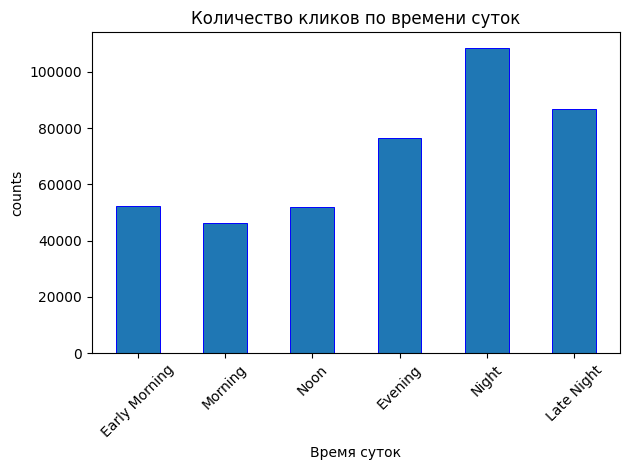

Клики в разные дни:
Monday: 44820
Tuesday: 64079
Wednesday: 66471
Thursday: 68699
Friday: 75362
Saturday: 61229
Sunday: 41589


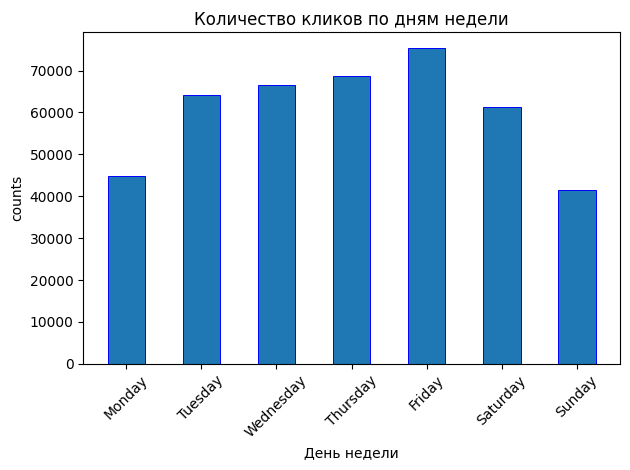

Клики в пятницу в разное время дня:
Early Morning: 12725
Morning: 9862
Noon: 11142
Evening: 12559
Night: 16960
Late Night: 12114


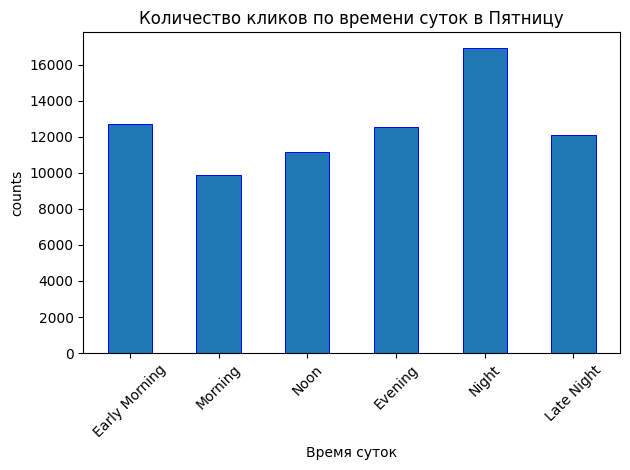

Клики по zone_id и типу баннера:
zone_id
0        5138
1       20269
2        8029
3        4577
4         157
        ...  
3439        0
3440        0
3441        0
3442        0
3443        0
Name: clicks, Length: 3444, dtype: int64
Клики по zone_id и типу баннера:
zone_id
14      93795
17      63758
27      29002
1       20269
11      11763
        ...  
2103        0
2102        0
2101        0
2100        0
3443        0
Name: clicks, Length: 3444, dtype: int64
Клики по zone_id и типу баннера:
banner_id
46      24751
22      18124
2       10377
361      9366
28       9326
        ...  
1365        0
1364        0
1363        0
1362        0
1632        0
Name: clicks, Length: 1633, dtype: int64


In [4]:

def analysis(data: pd.DataFrame):
    print(f"Пустые значения в данных: {data.isnull().sum().sum()}\nУникальные значения:\n zone_id - {data['zone_id'].nunique()}\n banner_id - {data['banner_id'].nunique()}\n country id - {data['country_id'].nunique()}")
    data['date'] = pd.to_datetime(data['date_time'], errors='coerce')
    data['time'] = [datetime.datetime.time(d) for d in data['date']] 
    data['day_of_the_week'] = data['date'].dt.day_of_week
    data['session'] = (data['date'].dt.hour % 24 + 4) // 4
    data['date'] = pd.to_datetime(data['date']).dt.date
    # data['session_num'], mapping_index = pd.Series(data.session).factorize()
    
    time_periods = {1: 'Early Morning', 2: 'Morning', 3: 'Noon', 4: 'Evening', 5: 'Night', 6: 'Late Night'}
    
    # data['clicks_per_time'] = [time_periods[period] for period in data['session']]
    print("АНАЛИЗ ДАТАСЕТА")
    feature_clicks = {}
    features = ['zone_id', 'banner_id', 'country_id']

    for feature in features:
        feature_clicks[feature] = data.groupby(feature)['clicks'].sum()

    top_3_values = {}
    for feature, clicks in feature_clicks.items():
        sorted_values = clicks.sort_values(ascending=False)[:3]
        top_3_values[feature] = sorted_values
    print("======================")


    for feature, top_values in top_3_values.items():
        print("======================")
        print(f"Top 3 значения для {feature} с наибольшим кол-во кликов:")
        print(top_values)
    

    
    data['date'] = pd.to_datetime(data['date_time'], errors='coerce')
    data['time'] = [datetime.datetime.time(d) for d in data['date']] 
    data['day_of_the_week']=data['date'].dt.day_of_week
    
    
#     data['session_num'],mapping_index = pd.Series(data.session).factorize()
    print("Количество кликов:")
    print(f' 0: {data["clicks"].value_counts()[0]} 1: {data["clicks"].value_counts()[1]}')
    data['session'] = (data['date'].dt.hour % 24 + 4) // 4
    time_periods = {1:'Early Morning', 2:'Morning', 3:'Noon', 4:'Evening', 5:'Night', 6:'Late Night'}
    clicks_per_time = {period: len(data[(data['clicks'] == 1) & (data['session'] == period)]) for period in time_periods.keys()}
    x=[]
    y = []
    print("======================")
    print("Клики в разные периоды времени:")
    for period, count in clicks_per_time.items():
        print(f"{time_periods[period]}: {count}")
        x.append(time_periods[period])
        y.append(count)
    print("======================")
    plotting(x,y,"Время суток","counts","Количество кликов по времени суток")
    x = []
    y = []
    days = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 0:'Sunday'}
    print("======================")
    print("Клики в разные дни:")
    for day in days.keys():
        count = len(data[(data['clicks'] == 1) & (data['day_of_the_week'] == day)])
        print(f"{days[day]}: {count}")
        x.append(days[day])
        y.append(count)
    print("======================")
    plotting(x,y,"День недели","counts","Количество кликов по дням недели")

    x=[]
    y = []
    print("======================")
    print("Клики в пятницу в разное время дня:")
    clicks_per_time = {period: len(data[(data['clicks'] == 1) & (data['session'] == period) & (data['day_of_the_week'] == 5)]) for period in time_periods.keys()}
    for period, count in clicks_per_time.items():
        print(f"{time_periods[period]}: {count}")
        x.append(time_periods[period])
        y.append(count)
    print("======================")
    plotting(x,y,"Время суток","counts","Количество кликов по времени суток в Пятницу")

    # Количество кликов по zone_id и типо баннера
    print("======================")
    print("Клики по zone_id и типу баннера:")
    zone_banner_clicks = data.groupby(['zone_id'])['clicks'].sum()
    print(zone_banner_clicks)
    print("======================")

     # Количество кликов по zone_id и типо баннера
    print("======================")
    print("Клики по zone_id и типу баннера:")
    zone_banner_clicks = data.groupby(['zone_id'])['clicks'].sum().sort_values(ascending=False)
    print(zone_banner_clicks)
    print("======================")
    print("Клики по zone_id и типу баннера:")
    zone_banner_clicks = data.groupby(['banner_id'])['clicks'].sum().sort_values(ascending=False)
    print(zone_banner_clicks)
    print("======================")




analysis(data)
    

Мое предположение потвердилось. Можно предположить, что пятница это день перед выходными, поэтому у людей больше свободного времени. Аналогично можно сказать и про время суток. Вечером люди возращаются с работы и заходят в интернет.

In [5]:
data['date'] = pd.to_datetime(data['date']).dt.date
data["date"].max() 

datetime.date(2021, 10, 2)

In [6]:
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,...,banner_id1,rate1,g1,coeff_sum1,impressions,clicks,date,time,day_of_the_week,session
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,...,0,0.010,0.049516,-5.369901,1,1,2021-09-27,00:01:30,0,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,...,269,0.004,0.031942,-4.449220,1,1,2021-09-26,22:54:49,6,6
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,...,21,0.014,0.014906,-3.939309,1,1,2021-09-26,23:57:20,6,6
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,...,99,0.006,0.050671,-3.418403,1,1,2021-09-27,00:04:30,0,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,...,11464230,6.790,0.032005,-2.828797,1,1,2021-09-27,00:06:21,0,1


In [7]:
def feature_engineering(X_train,X_test) -> pd.DataFrame:
    X_train_t = X_train.drop(['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1','date_time','time','date','impressions','campaign_clicks'], axis=1, inplace=False)
    X_test_t = X_test.drop(['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1','date_time','time','date','impressions','campaign_clicks'], axis=1, inplace=False)
    encoder = OneHotEncoder(handle_unknown='ignore').fit(X_train_t)

    X_train_t = encoder.transform(X_train_t)
    X_test_t = encoder.transform(X_test_t)
    return X_train_t,X_test_t

    

In [8]:
dropped_df = data[data['date'] == datetime.date(2021, 10, 2)]

In [9]:
new_df = data[data['date'] != datetime.date(2021, 10, 2)]

In [10]:
y_train = new_df['clicks']
y_test = dropped_df['clicks']

In [11]:
X_train = new_df.drop('clicks', axis=1)
X_test = dropped_df.drop('clicks', axis=1)

In [12]:
X_train_t,X_test_t = feature_engineering(X_train,X_test)



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Я убираю лишние фичи и перевожу все в onehotencoding и делаю фит на обучающей выборке, а трансформ для всего.Дальше я создаю логистическую регрессию и создаю кросс валидацию с 5 фолдами. Для нас важно подобрать коеффициенты которые максимизируют rocauc и минимизируют logross.

In [13]:
def create_model(solver='newton-cholesky'):
    return LogisticRegression(solver=solver)


def cv(X, y, model, cv=5):
    param_grid = {'C': [0.001, 0.01, 0.1, 1]}
    scoring = {
        'roc_auc': make_scorer(roc_auc_score, greater_is_better=True),
        'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
    }

    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scoring, refit='roc_auc')
    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    results = grid_search.cv_results_

    return best_params, results
    

In [15]:
log_reg_model = create_model()
best_params, cv_results = cv(X_train_t, y_train, log_reg_model, cv=5)
print(best_params, cv_results)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

{'C': 1} {'mean_fit_time': array([74.91768217, 80.41729007, 83.85719032, 93.86826711]), 'std_fit_time': array([6.72070452, 0.75188322, 5.43132882, 1.16267812]), 'mean_score_time': array([1.29144874, 1.31186819, 1.33089013, 1.29284115]), 'std_score_time': array([0.01961362, 0.02698068, 0.00988605, 0.02016859]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}], 'split0_test_roc_auc': array([0.5       , 0.50058412, 0.50123723, 0.50125529]), 'split1_test_roc_auc': array([0.5       , 0.5014848 , 0.50170605, 0.50173413]), 'split2_test_roc_auc': array([0.5       , 0.5014237 , 0.5020214 , 0.50219212]), 'split3_test_roc_auc': array([0.5       , 0.50100036, 0.50127935, 0.50132062]), 'split4_test_roc_auc': array([0.5       , 0.50097462, 0.50097029, 0.50098498]), 'mean_test_roc_auc': array([0.5       , 0.50109352, 0.50144287, 0.50149743]),

In [28]:
best_model = LogisticRegression(solver='newton-cholesky'C=0.001)
best_model.fit(X_train_t, y_train)

probs = best_model.predict_proba(X_test_t)[:, 1]




/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [37]:
roc_auc = roc_auc_score(y_test, probs)
print(f"ROC AUC: {roc_auc:.4f}")
loss = log_loss(y_test, probs)
print(f"Log Loss: {loss:.4f}")

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

ROC AUC: 0.7798


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Log Loss: 0.1338


In [33]:
pred = np.ones_like(y_test) * y_test.mean()
baseline = (y_test == 0).sum() / len(y_test)
print(f"auc: {roc_auc_score(y_test, pred)}")
print(f"log_loss: {log_loss(y_test, pred)}")



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

auc: 0.5


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

log_loss: 0.15303289904918538


Побили безлайн!!!